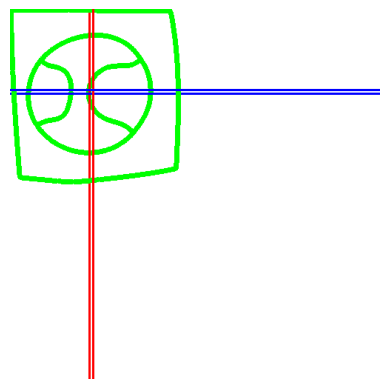

In [2]:
import cv2
import numpy as np
import csv
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

def load_points_from_csv(file_path):
    points = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            x, y = map(float, row[2:4])  # Adjust indexing if needed
            points.append((x, y))
    return np.array(points)

def cluster_points(points, eps=5, min_samples=3):
    # Use DBSCAN to cluster points into groups
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = clustering.labels_
    unique_labels = set(labels)
    clusters = [points[labels == label] for label in unique_labels if label != -1]  # Exclude noise points (-1)
    return clusters

def calculate_symmetry_lines(points):
    # Calculate median x and y coordinates to determine vertical and horizontal symmetry lines
    median_x = np.median(points[:, 0])
    median_y = np.median(points[:, 1])
    return median_x, median_y

def draw_shapes_with_symmetry_lines(img, clusters):
    for points in clusters:
        # Draw the shape
        for i in range(len(points)):
            cv2.circle(img, (int(points[i][0]), int(points[i][1])), 3, (0, 255, 0), -1)

        # Calculate and draw symmetry lines
        median_x, median_y = calculate_symmetry_lines(points)
        cv2.line(img, (int(median_x), 0), (int(median_x), img.shape[0]), (0, 0, 255), 2)  # Vertical symmetry
        cv2.line(img, (0, int(median_y)), (img.shape[1], int(median_y)), (255, 0, 0), 2)  # Horizontal symmetry

def main():
    # Path to the CSV file containing hand-drawn shape points
    csv_file_path = '/content/sample_data/frag1.csv'  # Update this path with the correct CSV file path

    # Load points from the CSV file
    points = load_points_from_csv(csv_file_path)

    # Cluster points into different shapes
    clusters = cluster_points(points)

    # Create a blank image to draw on
    img = np.zeros((500, 500, 3), dtype=np.uint8) + 255

    # Draw the shapes with symmetry lines
    draw_shapes_with_symmetry_lines(img, clusters)

    # Display the resulting image with the shapes and symmetry lines using matplotlib
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()

if __name__ == "__main__":
    main()

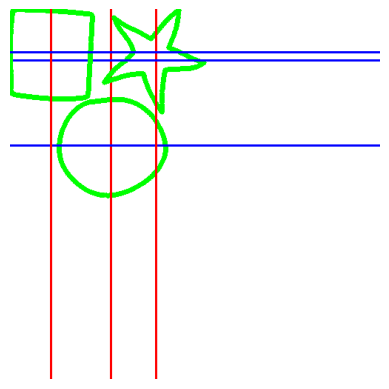

In [3]:
import cv2
import numpy as np
import csv
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

def load_points_from_csv(file_path):
    points = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            x, y = map(float, row[2:4])  # Adjust indexing if needed
            points.append((x, y))
    return np.array(points)

def cluster_points(points, eps=5, min_samples=3):
    # Use DBSCAN to cluster points into groups
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = clustering.labels_
    unique_labels = set(labels)
    clusters = [points[labels == label] for label in unique_labels if label != -1]  # Exclude noise points (-1)
    return clusters

def calculate_symmetry_lines(points):
    # Calculate median x and y coordinates to determine vertical and horizontal symmetry lines
    median_x = np.median(points[:, 0])
    median_y = np.median(points[:, 1])
    return median_x, median_y

def draw_shapes_with_symmetry_lines(img, clusters):
    for points in clusters:
        # Draw the shape
        for i in range(len(points)):
            cv2.circle(img, (int(points[i][0]), int(points[i][1])), 3, (0, 255, 0), -1)

        # Calculate and draw symmetry lines
        median_x, median_y = calculate_symmetry_lines(points)
        cv2.line(img, (int(median_x), 0), (int(median_x), img.shape[0]), (0, 0, 255), 2)  # Vertical symmetry
        cv2.line(img, (0, int(median_y)), (img.shape[1], int(median_y)), (255, 0, 0), 2)  # Horizontal symmetry

def main():
    # Path to the CSV file containing hand-drawn shape points
    csv_file_path = '/content/sample_data/isolated.csv'  # Update this path with the correct CSV file path

    # Load points from the CSV file
    points = load_points_from_csv(csv_file_path)

    # Cluster points into different shapes
    clusters = cluster_points(points)

    # Create a blank image to draw on
    img = np.zeros((500, 500, 3), dtype=np.uint8) + 255

    # Draw the shapes with symmetry lines
    draw_shapes_with_symmetry_lines(img, clusters)

    # Display the resulting image with the shapes and symmetry lines using matplotlib
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()

if __name__ == "__main__":
    main()

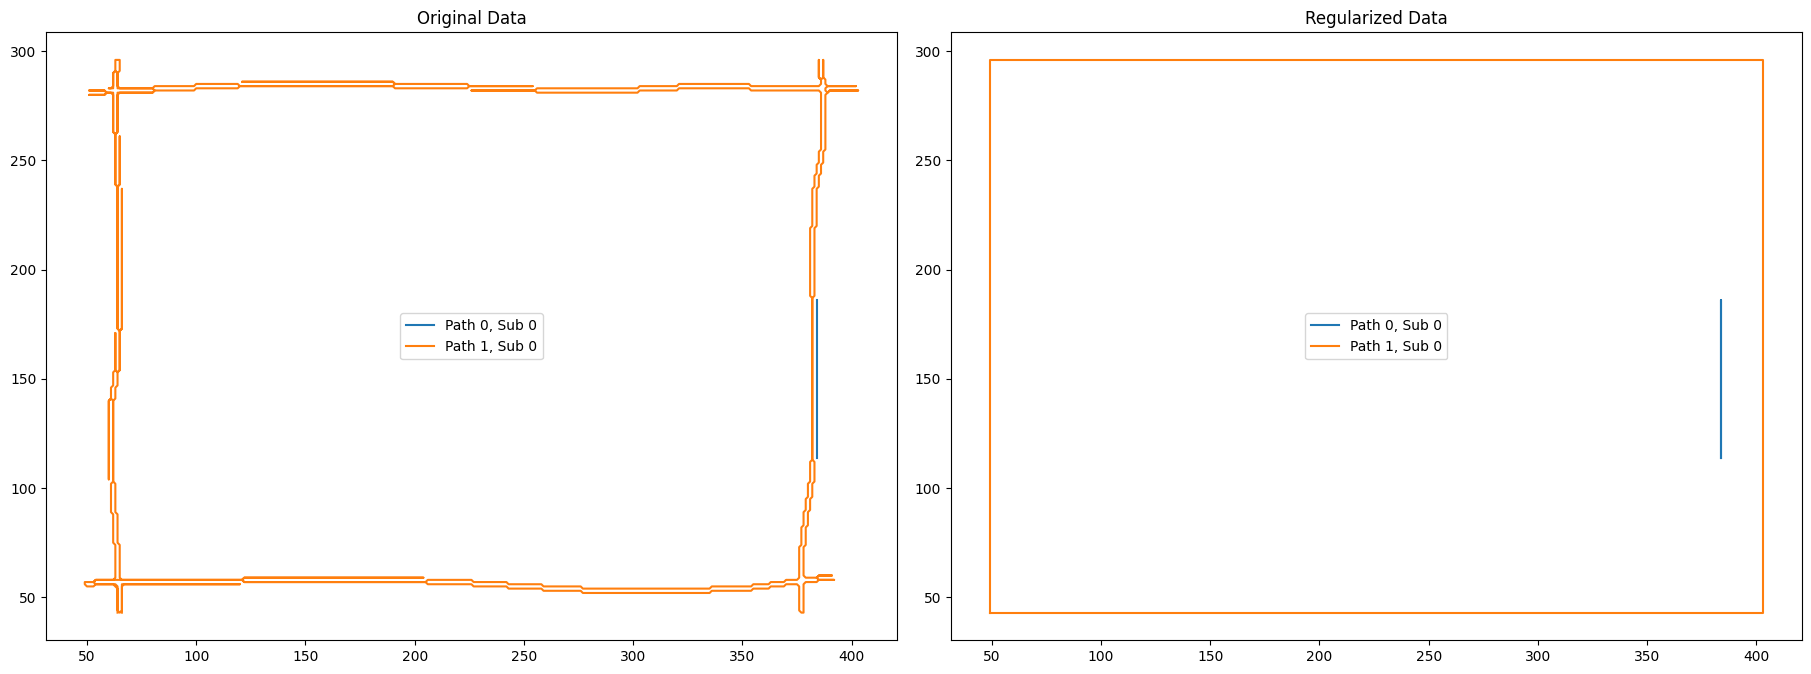

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

def load_and_process_image(file_path):
    # Load image in grayscale
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    # Perform edge detection
    edges = cv2.Canny(image, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    paths = {}
    for i, contour in enumerate(contours):
        contour = contour.squeeze()
        if len(contour.shape) == 1:  # Skip invalid contours
            continue
        paths[i] = {0: contour}  # Use i as path_id and assume single sub_id 0

    return paths

def fit_circle(points):
    def calc_R(c):
        return np.sqrt((points[:, 0] - c[0])**2 + (points[:, 1] - c[1])**2)

    def f(c):
        Ri = calc_R(c)
        return Ri - Ri.mean()

    center_estimate = np.mean(points, axis=0)
    result = least_squares(f, center_estimate)
    center = result.x
    radius = np.mean(calc_R(center))
    circle_points = np.array([
        [center[0] + radius * np.cos(theta), center[1] + radius * np.sin(theta)]
        for theta in np.linspace(0, 2 * np.pi, len(points))
    ])
    return circle_points

def fit_rectangle(points):
    min_x, max_x = np.min(points[:, 0]), np.max(points[:, 0])
    min_y, max_y = np.min(points[:, 1]), np.max(points[:, 1])
    rectangle_points = np.array([
        [min_x, min_y],
        [max_x, min_y],
        [max_x, max_y],
        [min_x, max_y],
        [min_x, min_y]  # Close the rectangle
    ])
    return rectangle_points

def identify_shape(points):
    x_range = np.max(points[:, 0]) - np.min(points[:, 0])
    y_range = np.max(points[:, 1]) - np.min(points[:, 1])
    aspect_ratio = x_range / y_range

    if 0.9 < aspect_ratio < 1.1:  # Nearly equal aspect ratio, likely a circle
        return 'circle'
    else:
        return 'rectangle'

def regularize_shape(points):
    shape_type = identify_shape(points)
    if shape_type == 'circle':
        return fit_circle(points)
    elif shape_type == 'rectangle':
        return fit_rectangle(points)
    else:
        return points  # Return original points if the shape doesn't match known types

def regularize_paths(paths):
    regularized_paths = {}
    for path_id, sub_paths in paths.items():
        regularized_paths[path_id] = {}
        for sub_id, points in sub_paths.items():
            regularized_paths[path_id][sub_id] = regularize_shape(points)
    return regularized_paths

def plot_paths(paths, title, ax):
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, (path_id, sub_paths) in enumerate(paths.items()):
        color = color_cycle[i % len(color_cycle)]
        for sub_id, points in sub_paths.items():
            ax.plot(points[:, 0], points[:, 1], '-', color=color, label=f'Path {int(path_id)}, Sub {int(sub_id)}')
    ax.set_aspect('equal', 'box')
    ax.set_title(title)
    ax.legend(loc='best')

# Define file paths
file_path_image = "/content/sample_data/rectangle2.jpeg"  # Replace with your actual image file path

# Load and process the image data
original_data = load_and_process_image(file_path_image)

# Regularize the hand-drawn paths
regularized_data = regularize_paths(original_data)

# Set up the plot
fig, axs = plt.subplots(1, 2, figsize=(18, 9), constrained_layout=True)

# Plot the original and regularized data
plot_paths(original_data, 'Original Data', axs[0])
plot_paths(regularized_data, 'Regularized Data', axs[1])

# Display the plots
plt.show()


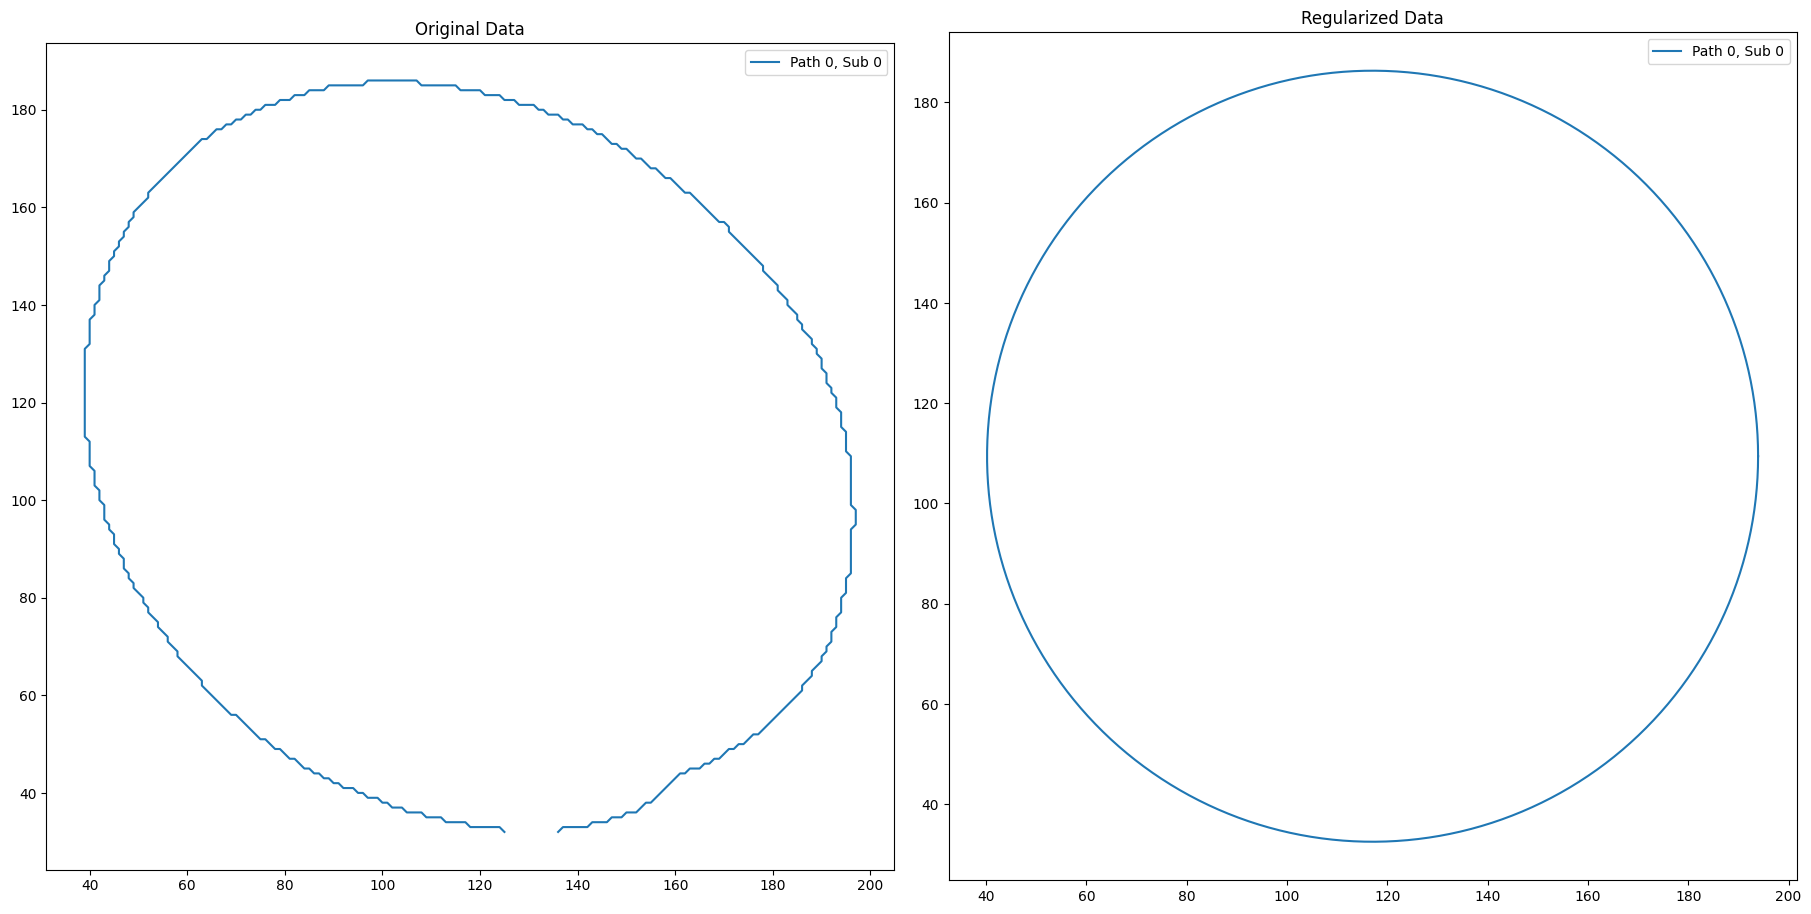

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

def load_and_process_image(file_path):
    # Load image in grayscale
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    # Perform edge detection
    edges = cv2.Canny(image, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    paths = {}
    for i, contour in enumerate(contours):
        contour = contour.squeeze()
        if len(contour.shape) == 1:  # Skip invalid contours
            continue
        paths[i] = {0: contour}  # Use i as path_id and assume single sub_id 0

    return paths

def fit_circle(points):
    def calc_R(c):
        return np.sqrt((points[:, 0] - c[0])**2 + (points[:, 1] - c[1])**2)

    def f(c):
        Ri = calc_R(c)
        return Ri - Ri.mean()

    center_estimate = np.mean(points, axis=0)
    result = least_squares(f, center_estimate)
    center = result.x
    radius = np.mean(calc_R(center))
    circle_points = np.array([
        [center[0] + radius * np.cos(theta), center[1] + radius * np.sin(theta)]
        for theta in np.linspace(0, 2 * np.pi, len(points))
    ])
    return circle_points

def fit_rectangle(points):
    min_x, max_x = np.min(points[:, 0]), np.max(points[:, 0])
    min_y, max_y = np.min(points[:, 1]), np.max(points[:, 1])
    rectangle_points = np.array([
        [min_x, min_y],
        [max_x, min_y],
        [max_x, max_y],
        [min_x, max_y],
        [min_x, min_y]  # Close the rectangle
    ])
    return rectangle_points

def identify_shape(points):
    x_range = np.max(points[:, 0]) - np.min(points[:, 0])
    y_range = np.max(points[:, 1]) - np.min(points[:, 1])
    aspect_ratio = x_range / y_range

    if 0.9 < aspect_ratio < 1.1:  # Nearly equal aspect ratio, likely a circle
        return 'circle'
    else:
        return 'rectangle'

def regularize_shape(points):
    shape_type = identify_shape(points)
    if shape_type == 'circle':
        return fit_circle(points)
    elif shape_type == 'rectangle':
        return fit_rectangle(points)
    else:
        return points  # Return original points if the shape doesn't match known types

def regularize_paths(paths):
    regularized_paths = {}
    for path_id, sub_paths in paths.items():
        regularized_paths[path_id] = {}
        for sub_id, points in sub_paths.items():
            regularized_paths[path_id][sub_id] = regularize_shape(points)
    return regularized_paths

def plot_paths(paths, title, ax):
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, (path_id, sub_paths) in enumerate(paths.items()):
        color = color_cycle[i % len(color_cycle)]
        for sub_id, points in sub_paths.items():
            ax.plot(points[:, 0], points[:, 1], '-', color=color, label=f'Path {int(path_id)}, Sub {int(sub_id)}')
    ax.set_aspect('equal', 'box')
    ax.set_title(title)
    ax.legend(loc='best')

# Define file paths
file_path_image = "/content/sample_data/cir3.png"  # Replace with your actual image file path

# Load and process the image data
original_data = load_and_process_image(file_path_image)

# Regularize the hand-drawn paths
regularized_data = regularize_paths(original_data)

# Set up the plot
fig, axs = plt.subplots(1, 2, figsize=(18, 9), constrained_layout=True)

# Plot the original and regularized data
plot_paths(original_data, 'Original Data', axs[0])
plot_paths(regularized_data, 'Regularized Data', axs[1])

# Display the plots
plt.show()


<ipython-input-12-59b0e1b2fb54>:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat([output_df, temp_df])


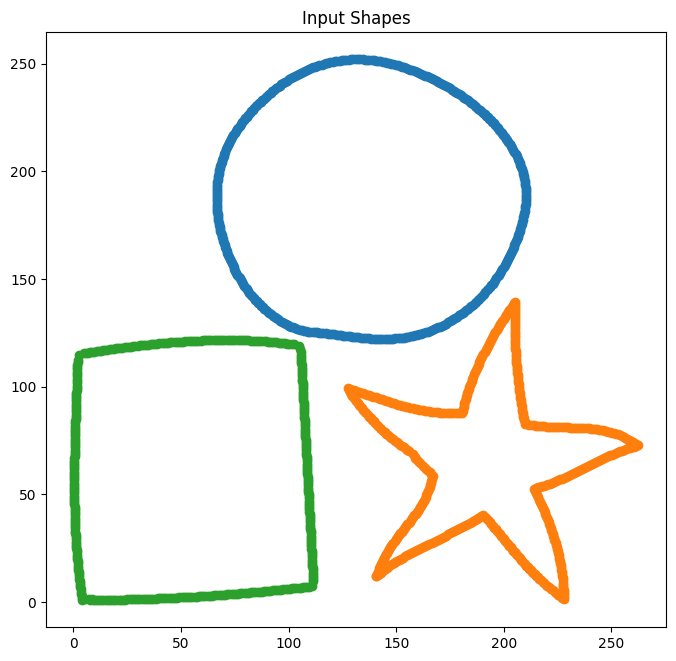

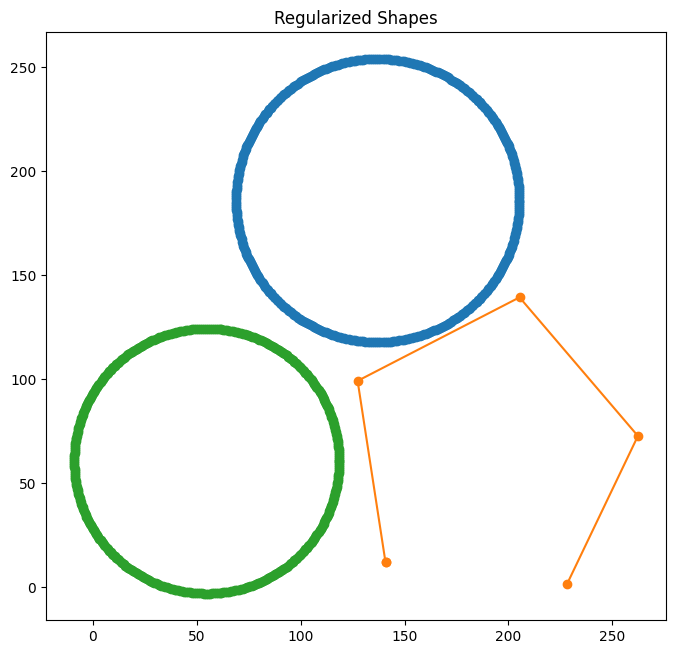

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from scipy.optimize import least_squares

# Load the CSV file
input_file = "/content/sample_data/isolated.csv"  # Adjust path accordingly
data = pd.read_csv(input_file)

# Rename columns for easier access
data.columns = ["x1", "y1", "x", "y"]
data = data[["x", "y"]]

# Detect connected components using DBSCAN
clustering = DBSCAN(eps=5, min_samples=3).fit(data)
data['shape_id'] = clustering.labels_

def fit_circle(points):
    """ Fit a circle to the given points. """
    # Handle the case where there are not enough points to fit a circle
    if len(points) < 3:
        return points

    def calc_R(xc, yc):
        return np.sqrt((points[:, 0] - xc) ** 2 + (points[:, 1] - yc) ** 2)

    def cost(params):
        Ri = calc_R(*params)
        return Ri - Ri.mean()

    center_estimate = np.mean(points, axis=0)
    result = least_squares(cost, center_estimate)
    center = result.x
    radius = calc_R(*center).mean()

    angle = np.linspace(0, 2 * np.pi, len(points))
    return np.array([center + radius * np.array([np.cos(a), np.sin(a)]) for a in angle])

# ... (rest of the code remains the same)
def regularize_polygon(points, n_sides):
    """ Regularize a polygon (rectangle or similar) to have equal sides and right angles. """
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]

    if n_sides == 4:
        x_coords = hull_points[:, 0]
        y_coords = hull_points[:, 1]

        min_x, max_x = np.min(x_coords), np.max(x_coords)
        min_y, max_y = np.min(y_coords), np.max(y_coords)

        return np.array([
            [min_x, min_y],
            [min_x, max_y],
            [max_x, max_y],
            [max_x, min_y]
        ])
    else:
        return hull_points

def regularize_star(points):
    """ Preserve the sharp points and smooth the edges of a star shape. """
    hull = ConvexHull(points)
    return points[hull.vertices]

def detect_shape(points):
    """ Detect the shape type and regularize it accordingly. """
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    num_vertices = len(hull_points)

    # Aspect ratio and vertex count for classification
    aspect_ratio = np.ptp(hull_points[:, 0]) / np.ptp(hull_points[:, 1])
    if num_vertices == 4 and (0.8 < aspect_ratio < 1.2):
        return regularize_polygon(points, 4)  # Likely a rectangle or square

    if num_vertices > 8:
        return fit_circle(points)  # Likely a circle

    if num_vertices >= 5:
        return regularize_star(points)  # Likely a star shape

    return points  # Default case for irregular shapes

# Apply detection and regularization to each detected shape
shapes = data.groupby("shape_id").apply(lambda x: detect_shape(x[['x', 'y']].values))

# Convert back to DataFrame
output_df = pd.DataFrame(columns=["shape_id", "x", "y"])
for shape_id, points in shapes.items():
    temp_df = pd.DataFrame(points, columns=["x", "y"])
    temp_df["shape_id"] = shape_id
    output_df = pd.concat([output_df, temp_df])

# Save the output to a new CSV file
output_file = "regularized_output.csv"
output_df.to_csv(output_file, index=False)

# Visualization
def plot_shapes(df, title):
    plt.figure(figsize=(8, 8))
    for shape_id in df["shape_id"].unique():
        shape_points = df[df["shape_id"] == shape_id][["x", "y"]].values
        plt.plot(shape_points[:, 0], shape_points[:, 1], marker='o')
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Plot input shapes
plot_shapes(data, "Input Shapes")

# Plot regularized shapes
plot_shapes(output_df, "Regularized Shapes")